# Import libs

In [1]:
import sys
import os
utils_dir = '../../src/utils'
sys.path.insert(0, utils_dir) # add utils dir to path
import testbed_utils as tu
import time

TODO:

- check overall page load time result
- check rlb reward evolvement
- check weight assignments
- if result is good, test different capacity ratio -> scale up to larger and different trace (transfer learning compare -- with or without pretrained models
- if result is bad, try simplest sac model and reduce server number to 2 (increase action space to 2)

# Plot

In [144]:
import os
import numpy as np
from pylab import *
from matplotlib import pyplot as plt
import pandas as pd
import json

COLORS = ["#3978af", 
          "#d1342b",
          "#559d3f",
          "#ef8532", 
          "#634295", 
          "#a65d34", 
          "#aecde1", 
          "#b4dc93",
          "#ee9e9b", 
          "#f4c07b", 
          "#c6b4d3",
          "#fffea6",
          "#df3583"
]


LINE_STYLE = ['-',
              '-.',
              '--',
              ':',
             ]
MARKER_STYLE = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+"]
%matplotlib inline

In [473]:
def calcul_fair(values):
    '''
    @brief:
        calculate fairness
    @params:
        values: a list of values
    '''
    n = len(values)
    assert n > 0, 'fairness: list has no element'
    if not isinstance(values, np.ndarray): values = np.array(values)
    if values.sum() != 0.: 
        return pow(values.sum(), 2)/(n*sum(pow(values, 2)))
    else:
        return 1.
    
def calcul_over(values):
    '''
    @brief:
        calculate over-provision factor
    @params:
        values: a list of values
    '''
    n = len(values)
    assert n > 0, 'overprovision: list has no element'
    if not isinstance(values, np.ndarray): values = np.array(values)
    if values.mean() != 0.: 
        return values.max()/values.mean()
    else:
        return 1.

def read_file(filename):
    lines = []
    with open(filename, 'r') as myfile:
        lines = [line.rstrip('\n') for line in myfile]
    return lines

def get_page_load_time(filename, ep=None, verbose=False):
    traces = !ls {filename}
    traces = [t for t in traces if 'trace' in t]
    if ep:
        if ep == -1:
            traces = [t for t in traces if 'ep' not in t]
        else:
            traces = [t for t in traces if 'ep{}'.format(ep) in t]

    
    page_load_time = []
    if 'wiki' in filename:
        page_load_time_wiki = []
        page_load_time_static = []
    plt_by_ep = {}
    n_timeout = 0
    n_reset = 0
    n_sent = 0
    n_encode = 0
    n_404 = 0
    n_closed = 0
    
    for t in traces:
        if verbose: print("parsing trace {}".format(t))
        ep = int(t.replace('.log', '').split('ep')[-1])
        plt_by_ep[ep] = {}
        plt_all, plt_wiki, plt_static = [], [], []
        wiki_log = read_file(os.path.join(filename, t))
        for line in wiki_log:
            _ = line.split(' ')[-1]
            if ' failed ' not in line:
                plt_all.append(float(_))
                if 'wiki/index.php' in line:
                    plt_wiki.append(float(_))
                else:
                    plt_static.append(float(_))
                
            elif '[Errno 110]' in line:
                n_timeout += 1
            elif '[Errno 104]' in line:
                n_reset += 1
            elif 'Request-sent' in line:
                n_sent +=1
            elif 'HTTP_404' in line:
                n_404 += 1
            elif "\'ascii\' codec can\'t encode" in line:
                n_encode += 1
            elif "closed connection without response" in line:
                n_closed += 1
            else:
                print(line)
        
        # log if verbose
        if verbose:
            if 'wiki' in filename:
                for k, plt_ in zip(['all', 'wiki', 'static'], [plt_all, plt_wiki, plt_static]):
    #             for k, plt_ in zip(['all'], [plt_all]):
                    plt_ = np.array(plt_)
                    print("plt {}: mean - {:.4f} median - {:.4f} 99p - {:.4f}".format(k, plt_.mean(), np.median(plt_), np.percentile(plt_, 99)))
                    plt_by_ep[ep][k] = plt_
            else:
                plt_ = np.array(plt_all)
                print("plt: mean - {:.4f} median - {:.4f} 99p - {:.4f}".format(plt_.mean(), np.median(plt_), np.percentile(plt_, 99)))
                plt_by_ep[ep] = plt_
        page_load_time += plt_all
        if 'wiki' in filename:
            page_load_time_wiki += plt_wiki
            page_load_time_static += plt_static

    res = {
        'page_load_time': page_load_time, 
        'timeout': n_timeout, 
        'n_reset': n_reset,
        'n_sent': n_sent,
        'n_404': n_404,
        'plt_by_ep': plt_by_ep
    }
    if 'wiki' in filename:
        res.update({'plt_wiki': page_load_time_wiki, 
        'plt_static': page_load_time_static})
    return res
    
def get_metrics(filename):
    '''
    @brief:
        get metrics w.r.t. CPU usage and number of busy Apache threads
    '''

    
    res = {
        "cpu": {
            "mean": [],
            "fair": [],
            "over": [],
        },
        "apache": {
            "mean": [],
            "fair": [],
            "over": [],            
        },
    }
    
    gt = pd.read_csv(os.path.join(filename, 'log', 'shm.csv'))
    
    for i in range(int(len(gt) / n_as)):
        for label in ["cpu", "apache"]:
            values = gt.iloc[(i*n_as):(i*n_as+n_as)][label].values
            res[label]["mean"].append(np.mean(values))
            res[label]["fair"].append(calcul_fair(values))
            res[label]["over"].append(max(values)/max(1e-6, np.mean(values)))
    return res

def plot_cdf_from_dict(
    dict_data,
    color_dict,
    marker_dict,
    linestyle_dict,
    filename=None, 
    xlim=[0.01, 100], 
    xlabel=None,
    ylabel='CDF',
    verbose=False,
    semilogx=True,
):
    f = plt.figure(figsize=(8,3), dpi=96)
    for k, v in dict_data.items():
        if verbose:
            print("plot {}".format(k))
        color = color_dict[k]
        marker = marker_dict[k]
        linestyle = linestyle_dict[k]
        percentiles = [np.percentile(v, p) for p in range(0, 110, 10)]
        if semilogx:
            plt.semilogx(np.sort(v), np.linspace(0, 1, len(v), endpoint=False), color=color)
            plt.semilogx(percentiles, np.linspace(0, 1, 11, endpoint=True), linestyle='', marker=marker, color=color)
        else:
            plt.plot(np.sort(v), np.linspace(0, 1, len(v), endpoint=False), color=color)
            plt.plot(percentiles, np.linspace(0, 1, 11, endpoint=True), linestyle='', marker=marker, color=color)
        plt.plot([0.], [0.], linestyle=linestyle, marker=marker, color=color, label=k)

    plt.xlim(xlim)
    plt.ylim([0.,1.])
    plt.legend(loc='lower right')
    if xlabel: plt.xlabel(xlabel)
    if ylabel: plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()
    if filename is not None:
        f.savefig(filename, bbox_inches='tight', transparent=True)
    return f

In [438]:
COLORS_DICT = {
    'sed': "#634259", 
    'rlb-qmix': "#17b6c8", 
    'rlb-iql': "#3978af", 
    'rlb-sac-gru-discrete': '#559d3f',
    'lsq': "#aecde1",
    'lsq2': "#634295",
    'active-wcmp': "#a65d34",
    'wcmp': "#ef8532", 
    'ecmp': "#d1342b", 
}

MARKER_DICT = {
    'lsq2':       "+",
    'ecmp':       ".",
    'lsq':       "o",
    'sed':    "^",
    'rlb-qmix':    "x",
    'rlb-iql': "*",
    'active-wcmp': "3",
    'wcmp':   ">",
    'rlb-sac-gru-discrete':   "v",
}

LINESTYLE_DICT = {
    'lsq2':       "-",
    'active-wcmp': '-',
    'ecmp':       "-",
    'lsq':       "-",
    'sed':    "-",
    'rlb-qmix':    "-",
    'rlb-iql': "-",
    'wcmp':   "-",
    'rlb-sac-gru-discrete':   "-",
}

METHOD_MAPPER = {
    'sed': "SED", 
    'rlb-qmix': "RLB-QMix", 
    'rlb-sac-gru-discrete': 'RLB-S-SAC',
    'lsq': "LSQ",
    'lsq2': "LSQ2",
    'active-wcmp': "AWCMP",
    'wcmp': "WCMP", 
    'ecmp': "ECMP", 
    'rlb-iql': "RLB-I-SAC",
}

In [155]:
def plt_summary(plt_dict):
    line2put = ''
    for k, v in plt_dict.items():
        if k is 'page_load_time':
            line2put += '  n_sample: {}\n'.format(len(v))
            line2put += '  avg. plt: {:.6f} \n'.format(np.mean(v))
            line2put += '  median. plt: {:.6f} \n'.format(np.percentile(v, 50))
            line2put += '  90p. plt: {:.6f} \n'.format(np.percentile(v, 90))
        else:
            line2put += '  {}: {}\n'.format(k, v)
    print(line2put)
    
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

import seaborn as sns
sns.set(style="ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in","xtick.top":True,"ytick.right":True,"axes.grid":True})

def get_task_name_dir(trace, lb_method, config):
    '''
    @brief:
        initialize task name and corresponding directory to store results
    @params:
        lb_method: name of the load balancing method
        trace: type of the networking trace to be replayed
        config: name of a configuration
    @return:
        task_name: name of the task
        task_dir: directory to store experiment result for this task
        
    '''
    global root_dir
    task_dir = os.path.join(root_dir, lb_method, config)
    task_name = '-'.join([trace, lb_method, config])
    return task_name, task_dir

In [416]:
root_dir = "../../data/results/ijcai-lb/wiki_600"
fig_dir = "../../data/figures/ijcai"

In [426]:
methods = ['rlb-qmix', 'rlb-iql', 'rlb-sac-gru-discrete']
# methods = ['rlb-sac-gru-discrete']
conf = 'conf01'
trace = 'wiki_600'

In [427]:
# hours with more than 500 queries/s
hours = [0, 1, 2, 3, 4, 5, 6, 7, 8, 16, 17, 18, 19, 20, 21, 22, 23]
hours2train = [h for h in hours if h%2 != 0]
hours2test = [h for h in hours if h%2 == 0]

In [436]:
page_load_time_res = {}
page_load_time_by_eps = {method: {} for method in methods}
for hour in hours2train:
    print("working on config:", config)
    page_load_time_res[hour] = {}
    for method in methods:
        if 'gru' in method:
            config = 'hour{:d}-{}'.format(hour, '1lb-conf01')
        else:
            config = 'hour{:d}-{}'.format(hour, conf)
        print(">> loading method:", method)
        _task, _dir = get_task_name_dir(trace, method, config)
        page_load_time_res[hour][method] = get_page_load_time(_dir, verbose=True)
        page_load_time_by_eps[method].update(page_load_time_res[hour][method]['plt_by_ep'])

working on config: hour23-1lb-conf01
>> loading method: rlb-qmix
parsing trace trace_ep0.log
plt all: mean - 0.7691 median - 0.5475 99p - 3.5635
plt wiki: mean - 1.0375 median - 0.8409 99p - 3.8288
plt static: mean - 0.5567 median - 0.3985 99p - 3.1760
parsing trace trace_ep1.log
plt all: mean - 0.1168 median - 0.0160 99p - 1.2742
plt wiki: mean - 0.2208 median - 0.1037 99p - 1.4881
plt static: mean - 0.0346 median - 0.0019 99p - 0.6555
parsing trace trace_ep24.log
plt all: mean - 0.1262 median - 0.0163 99p - 1.3642
plt wiki: mean - 0.2392 median - 0.1103 99p - 1.5604
plt static: mean - 0.0370 median - 0.0019 99p - 0.9183
parsing trace trace_ep25.log
plt all: mean - 0.6600 median - 0.3738 99p - 3.6893
plt wiki: mean - 0.8684 median - 0.6238 99p - 3.9876
plt static: mean - 0.4947 median - 0.2378 99p - 2.7707
parsing trace trace_ep26.log
plt all: mean - 0.2427 median - 0.0383 99p - 2.0248
plt wiki: mean - 0.3739 median - 0.1146 99p - 2.3227
plt static: mean - 0.1391 median - 0.0021 99p -

plt all: mean - 0.5747 median - 0.1381 99p - 3.7634
plt wiki: mean - 0.7445 median - 0.2708 99p - 4.0421
plt static: mean - 0.4286 median - 0.0028 99p - 3.1659
parsing trace trace_ep76.log
plt all: mean - 0.5204 median - 0.1218 99p - 3.2199
plt wiki: mean - 0.6914 median - 0.2203 99p - 3.5899
plt static: mean - 0.3733 median - 0.0032 99p - 2.0705
parsing trace trace_ep77.log
plt all: mean - 0.0507 median - 0.0106 99p - 0.5184
plt wiki: mean - 0.1017 median - 0.0608 99p - 0.6973
plt static: mean - 0.0067 median - 0.0018 99p - 0.1476
>> loading method: rlb-iql
parsing trace trace_ep27.log
plt all: mean - 0.2852 median - 0.0364 99p - 2.2862
plt wiki: mean - 0.4061 median - 0.1184 99p - 2.5699
plt static: mean - 0.1812 median - 0.0021 99p - 1.5739
parsing trace trace_ep28.log
plt all: mean - 0.0733 median - 0.0126 99p - 0.8906
plt wiki: mean - 0.1420 median - 0.0690 99p - 1.1048
plt static: mean - 0.0141 median - 0.0019 99p - 0.3041
parsing trace trace_ep29.log
plt all: mean - 0.0430 media

plt all: mean - 0.0617 median - 0.0092 99p - 0.6777
plt wiki: mean - 0.1295 median - 0.0699 99p - 0.8732
plt static: mean - 0.0068 median - 0.0018 99p - 0.1244
parsing trace trace_ep8.log
plt all: mean - 0.0554 median - 0.0094 99p - 0.6483
plt wiki: mean - 0.1107 median - 0.0626 99p - 0.7922
plt static: mean - 0.0105 median - 0.0018 99p - 0.1639
>> loading method: rlb-sac-gru-discrete
parsing trace trace_ep30.log
plt all: mean - 0.5091 median - 0.3101 99p - 3.1245
plt wiki: mean - 0.8001 median - 0.6413 99p - 3.9529
plt static: mean - 0.2736 median - 0.1944 99p - 2.1375
parsing trace trace_ep31.log
plt all: mean - 1.3774 median - 0.9364 99p - 7.5929
plt wiki: mean - 1.6894 median - 1.2179 99p - 8.0244
plt static: mean - 1.1258 median - 0.6861 99p - 6.5886
parsing trace trace_ep32.log
plt all: mean - 0.4082 median - 0.2209 99p - 2.8280
plt wiki: mean - 0.6330 median - 0.4395 99p - 4.0458
plt static: mean - 0.2258 median - 0.0941 99p - 2.0562
parsing trace trace_ep54.log
plt all: mean - 

plt all: mean - 0.0436 median - 0.0088 99p - 0.6230
plt wiki: mean - 0.0769 median - 0.0446 99p - 0.7951
plt static: mean - 0.0144 median - 0.0019 99p - 0.2247
parsing trace trace_ep37.log
plt all: mean - 0.0348 median - 0.0091 99p - 0.2939
plt wiki: mean - 0.0685 median - 0.0448 99p - 0.4625
plt static: mean - 0.0053 median - 0.0018 99p - 0.0892
parsing trace trace_ep38.log
plt all: mean - 0.0312 median - 0.0048 99p - 0.2601
plt wiki: mean - 0.0597 median - 0.0408 99p - 0.3178
plt static: mean - 0.0062 median - 0.0018 99p - 0.0238
parsing trace trace_ep60.log
plt all: mean - 0.0303 median - 0.0041 99p - 0.2302
plt wiki: mean - 0.0617 median - 0.0435 99p - 0.3051
plt static: mean - 0.0027 median - 0.0018 99p - 0.0166
parsing trace trace_ep61.log
plt all: mean - 0.0275 median - 0.0042 99p - 0.1935
plt wiki: mean - 0.0557 median - 0.0413 99p - 0.2301
plt static: mean - 0.0028 median - 0.0018 99p - 0.0152
parsing trace trace_ep62.log
plt all: mean - 0.0285 median - 0.0047 99p - 0.2070
plt

plt all: mean - 0.0498 median - 0.0104 99p - 0.4919
plt wiki: mean - 0.0981 median - 0.0585 99p - 0.7607
plt static: mean - 0.0100 median - 0.0019 99p - 0.2134
parsing trace trace_ep65.log
plt all: mean - 0.0335 median - 0.0032 99p - 0.2670
plt wiki: mean - 0.0708 median - 0.0505 99p - 0.3227
plt static: mean - 0.0028 median - 0.0019 99p - 0.0198
>> loading method: rlb-sac-gru-discrete
parsing trace trace_ep15.log
plt all: mean - 0.4187 median - 0.2514 99p - 2.0581
plt wiki: mean - 0.6957 median - 0.5674 99p - 2.2422
plt static: mean - 0.1932 median - 0.1439 99p - 0.8330
parsing trace trace_ep16.log
plt all: mean - 0.2986 median - 0.0948 99p - 2.0186
plt wiki: mean - 0.4626 median - 0.2476 99p - 2.2849
plt static: mean - 0.1638 median - 0.0027 99p - 1.3558
parsing trace trace_ep17.log
plt all: mean - 0.0690 median - 0.0100 99p - 0.7590
plt wiki: mean - 0.1310 median - 0.0699 99p - 0.8208
plt static: mean - 0.0181 median - 0.0019 99p - 0.5868
parsing trace trace_ep39.log
plt all: mean -

plt wiki: mean - 0.2422 median - 0.1150 99p - 1.3943
plt static: mean - 0.0214 median - 0.0019 99p - 0.2969
parsing trace trace_ep45.log
plt all: mean - 0.0465 median - 0.0040 99p - 0.4292
plt wiki: mean - 0.0977 median - 0.0622 99p - 0.5784
plt static: mean - 0.0062 median - 0.0018 99p - 0.1146
parsing trace trace_ep46.log
plt all: mean - 0.1750 median - 0.0353 99p - 1.7249
plt wiki: mean - 0.3054 median - 0.1120 99p - 1.9897
plt static: mean - 0.0724 median - 0.0021 99p - 0.6683
parsing trace trace_ep47.log
plt all: mean - 0.0543 median - 0.0088 99p - 0.5659
plt wiki: mean - 0.1079 median - 0.0630 99p - 0.8436
plt static: mean - 0.0120 median - 0.0018 99p - 0.2577
parsing trace trace_ep69.log
plt all: mean - 0.0367 median - 0.0029 99p - 0.2933
plt wiki: mean - 0.0794 median - 0.0559 99p - 0.3584
plt static: mean - 0.0031 median - 0.0018 99p - 0.0198
parsing trace trace_ep70.log
plt all: mean - 0.0350 median - 0.0029 99p - 0.2789
plt wiki: mean - 0.0754 median - 0.0535 99p - 0.3429
pl

## Check FCT by episode

In [430]:
fct_mean_method = {}
fct_std_method = {}

In [437]:
n_ep = 72
for method in methods:
    fct_mean = []
    fct_std = []
    for ep in range(n_ep):
        fct_mean.append(np.mean(page_load_time_by_eps[method][ep]['all']))
        fct_std.append(np.std(page_load_time_by_eps[method][ep]['all']))
    fct_mean_method[method] = fct_mean
    fct_std_method[method] = fct_std

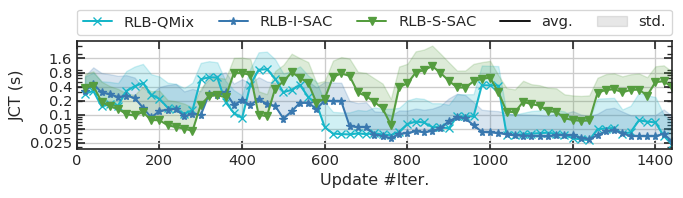

In [454]:
n_ep = 72
fig = plt.figure(figsize=(8, 1.5), dpi=96)
box_smooth = 3

for method in methods:
    plt.plot(np.array(range(1, n_ep+1))*20, smooth(fct_mean_method[method], box_smooth), '-', color=COLORS_DICT[method], marker=MARKER_DICT[method])
    plt.fill_between(np.array(range(1, n_ep+1))*20, smooth(fct_mean_method[method], box_smooth), smooth(fct_mean_method[method], box_smooth)+smooth(fct_std_method[method], box_smooth), color=COLORS_DICT[method], alpha=0.2)
    plt.plot(0, 0, color=COLORS_DICT[method], marker=MARKER_DICT[method], label=METHOD_MAPPER[method])
plt.plot(0, 0, '-', color='k', label='avg.')
plt.fill_between([0], [0], [0], color='k', alpha=0.1, label='std.')

plt.legend(bbox_to_anchor=(0., 1.05, 1., .102), loc='lower left',
               ncol=5, mode="expand", borderaxespad=0.)
plt.yscale('log')
plt.yticks([0.025, 0.05, 0.1, 0.2, 0.4, 0.8, 1.6], [0.025, 0.05, 0.1, 0.2, 0.4, 0.8, 1.6])
plt.xlabel('Update #Iter.')
plt.xlim(0, 72*20)
plt.ylabel('JCT (s)')
plt.show()
fig.savefig(os.path.join(fig_dir, 'wiki', 'train-jct.pdf'), bbox_inches='tight', transparent=True)

## Plot by episode

In [223]:
n_ep = 80
smooth_box = 5

In [224]:
_dir_hour0 = '../../data/results/ijcai-lb/wiki_600/rlb-sac-gru-discrete/hour0-conf01'

In [23]:
hour = 'hour2'
conf = '1lb-conf01'
_dir = _dir_hour0.replace('hour0', hour).replace('1lb-conf01', conf)

In [215]:
hours2train_eps = hours2train*5

In [232]:
[traffic_rates[h] for h in hours2test]

[796.3083333333333,
 687.44,
 690.855,
 696.5016666666667,
 518.7933333333333,
 520.9866666666667,
 731.53,
 758.7816666666666,
 784.5166666666667]

episode 75: missing logger file ../../data/results/ijcai-lb/wiki_600/rlb-sac-gru-discrete/hour3-conf01/1_log_ep75/logger.log
episode 76: missing logger file ../../data/results/ijcai-lb/wiki_600/rlb-sac-gru-discrete/hour3-conf01/1_log_ep76/logger.log
episode 78: missing logger file ../../data/results/ijcai-lb/wiki_600/rlb-sac-gru-discrete/hour5-conf01/1_log_ep78/logger.log
episode 79: missing logger file ../../data/results/ijcai-lb/wiki_600/rlb-sac-gru-discrete/hour5-conf01/1_log_ep79/logger.log


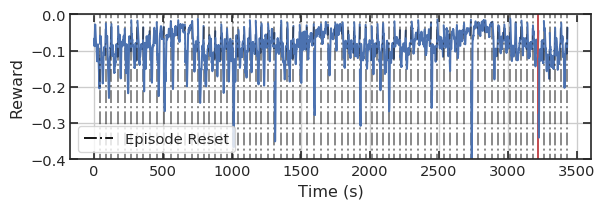

In [229]:
fig = plt.figure(figsize=(7,2), dpi=96)

ts_base = 0
for ep in range(n_ep):
    _dir = _dir_hour0.replace('hour0', 'hour{}'.format(hours2train_eps[int(ep/3)]))
    filename = os.path.join(_dir, '1_log_ep{}'.format(ep), 'logger.log')
    if not os.path.exists(filename):
        print("episode {}: missing logger file {}".format(ep, filename))
        continue
    lines = read_file(filename)
    rewards = [float(l.strip(' ').split('reward: ')[-1]) for l in lines if 'reward:' in l]
    if ep == 71 or ep==78:
        plt.plot([ts_base]*2, [-1., 0], color='r')
    tss = [ts_base+float(l.strip(' ').split('Time: ')[-1].split('s')[0]) for l in lines if 'Time' in l]
    plt.plot(tss, smooth(rewards, 20), color='b')
    plt.plot([tss[-1]]*2, [-1, 0], color='k',  linestyle='-.', alpha=0.5)
    ts_base = tss[-1]
    
# plt.plot(0, 0, color='b', label='Reward')
plt.plot(0, 0, color='k', linestyle='-.', label='Episode Reset')
plt.legend()
plt.ylim([-0.4, 0.])
# plt.yscale('log')
# plt.xlim([0, 2480.])
# plt.xlim([0, 3000.])
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.show()
# fig.savefig(os.path.join(fig_dir, '{}-{}-{}-reward.pdf'.format(method, hour, conf)), bbox_inches='tight', transparent=True)

## Check weight ratio

In [412]:
# methods = ['aqualight', 'rlb-sac-new']
methods_ratio = ['rlb-iql-test', 'rlb-qmix-test', 'rlb-sa-test']
hours = [0, 4, 6, 8]
config_fmt = "hour{}-conf01"
split_by = 3
ratio_str = r"$\frac{\overline{w}_{2CPU}}{\overline{w}_{1CPU}}$"
df_dict = {
    ratio_str: [],
    'Ratio Type': [],
    'Time': [],
    'Method': [],
}

In [413]:
for method in methods_ratio:
    for hour in hours:
        if 'rlb-sa' in method:
            conf = config_fmt.format(str(hour)+'-1lb')
        else:
            conf = config_fmt.format(hour)
        v = []
        for ep in range(5):
            if 'rlb' in method:
                filename = "../../data/results/ijcai-lb/wiki_600/{}/{}/0_log_ep{}/logger.log".format(method, conf, ep)
            else:
                filename = "../../data/results/ijcai-lb/wiki_600/{}/{}/0_log_ep{}/lb.log".format(method, conf, ep)
            if not os.path.exists(filename): 
                continue
            lines = read_file(filename)
            lines = lines[int(0.25*len(lines)):int(0.75*len(lines))]
            for l in lines:
                if "Time: " in l:
                    t = float(l.split('Time: ')[-1].strip(" ").strip("s)"))
                if '#apache: ' in l:
                    values = [int(n) for n in l.split('#apache:')[-1].split('|')]
                    df_dict[ratio_str].append(np.mean(values[:split_by])/np.mean(values[split_by:]))
                    df_dict['Ratio Type'].append('Apache')
                    df_dict['Time'].append(t)
                    df_dict['Method'].append(method)
                elif 'Last action: ' in l:
                    values = [float(n)*0.2+1 for n in l.split('Last action:')[-1].split('|')]
                    ratio = np.mean(values[:split_by])/np.mean(values[split_by:])
                    df_dict[ratio_str].append(ratio)
                    df_dict['Ratio Type'].append('Server Weights')
                    df_dict['Time'].append(t)
                    df_dict['Method'].append(method)
                    v.append(ratio)
                else:
                    continue
        if len(v) > 0:
            print('method [{}] (traffic rate {}) #apache thread ratio: avg {:.3f} std {:.3f} median {:.3f} 90p {:.3f}'.format(METHOD_MAPPER[method], traffic_rates[hour], np.mean(v), np.std(v), np.median(v), np.percentile(v, 90)))

method [RLB-I-SAC] (traffic rate 796.3083333333333) #apache thread ratio: avg 0.998 std 0.173 median 0.989 90p 1.237
method [RLB-I-SAC] (traffic rate 690.855) #apache thread ratio: avg 1.008 std 0.205 median 0.989 90p 1.282
method [RLB-I-SAC] (traffic rate 696.5016666666667) #apache thread ratio: avg 1.005 std 0.182 median 0.980 90p 1.244
method [RLB-I-SAC] (traffic rate 518.7933333333333) #apache thread ratio: avg 0.998 std 0.180 median 0.988 90p 1.237
method [RLB-QMix] (traffic rate 796.3083333333333) #apache thread ratio: avg 1.016 std 0.189 median 1.011 90p 1.278
method [RLB-QMix] (traffic rate 690.855) #apache thread ratio: avg 1.023 std 0.183 median 1.011 90p 1.238
method [RLB-QMix] (traffic rate 696.5016666666667) #apache thread ratio: avg 0.995 std 0.177 median 0.974 90p 1.235
method [RLB-QMix] (traffic rate 518.7933333333333) #apache thread ratio: avg 1.013 std 0.173 median 1.000 90p 1.226
method [RLB-S-SAC] (traffic rate 796.3083333333333) #apache thread ratio: avg 0.980 std 

In [384]:
df_ratio = pd.DataFrame.from_dict(df_dict)

(0, 2)

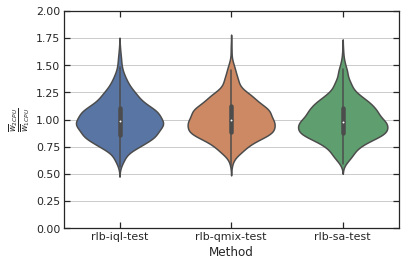

In [385]:
sns.violinplot(x='Method', y=ratio_str, data=df_ratio.loc[df_ratio['Ratio Type'] == 'Server Weights'])
plt.ylim(0, 2)

In [554]:
methods = ['ecmp', 'wcmp', 'active-wcmp', 'rlb-iql-test', 'rlb-qmix-test', 'rlb-sa-test', 'sed']
hours = [0, 4, 6, 8]
config_fmt = "hour{}-conf01"
split_by = 3
df_dict = {
    'AS Group': [],
    '#Apache': [],
    'Method': [],
    'Hour': []
}

In [559]:
for method in methods:
    for hour in hours:
        if 'rlb-sa' in method:
            conf = config_fmt.format(str(hour)+'-1lb')
        else:
            conf = config_fmt.format(hour)
        v = [] # ratio
        for ep in range(5):
            if 'rlb' in method:
                filename = "../../data/results/ijcai-lb/wiki_600/{}/{}/0_log_ep{}/logger.log".format(method, conf, ep)
            else:
                filename = "../../data/results/ijcai-lb/wiki_600/{}/{}/0_log_ep{}/lb.log".format(method, conf, ep)
            if not os.path.exists(filename): 
                continue
            lines = read_file(filename)
            lines = lines[int(0.25*len(lines)):int(0.75*len(lines))]
            for l in lines:
                if "Time: " in l:
                    t = float(l.split('Time: ')[-1].strip(" ").strip("s)"))
                if '#apache: ' in l:
                    values = [int(n) for n in l.split('#apache:')[-1].split('|')]
                    n_apache0 = np.mean(values[:split_by])
                    n_apache1 = np.mean(values[split_by:])
                    df_dict['#Apache'].append(n_apache0)
                    df_dict['AS Group'].append('4-CPU')
                    df_dict['Method'].append(METHOD_MAPPER[method])
                    df_dict['Hour'].append(hour)
                    df_dict['#Apache'].append(n_apache1)
                    df_dict['AS Group'].append('2-CPU')
                    df_dict['Method'].append(METHOD_MAPPER[method])
                    df_dict['Hour'].append(hour)
                    v.append(n_apache0/(n_apache1+1e-9))
                else:
                    continue
        if len(v) > 0:
            print('method [{}] (traffic rate {}) #apache thread ratio: avg {:.3f} std {:.3f} median {:.3f} 90p {:.3f}'.format(METHOD_MAPPER[method], traffic_rates[hour], np.mean(v), np.std(v), np.median(v), np.percentile(v, 90)))

method [WCMP] (traffic rate 796.3083333333333) #apache thread ratio: avg 0.863 std 0.543 median 0.807 90p 1.408
method [WCMP] (traffic rate 690.855) #apache thread ratio: avg 1.319 std 1.082 median 1.037 90p 2.360
method [WCMP] (traffic rate 696.5016666666667) #apache thread ratio: avg 0.675 std 0.697 median 0.481 90p 1.486
method [WCMP] (traffic rate 518.7933333333333) #apache thread ratio: avg 14115094.449 std 246913272.297 median 1.556 90p 4.076
method [AWCMP] (traffic rate 796.3083333333333) #apache thread ratio: avg 1.174 std 0.878 median 0.991 90p 1.688
method [AWCMP] (traffic rate 690.855) #apache thread ratio: avg 0.962 std 0.605 median 0.852 90p 1.683
method [AWCMP] (traffic rate 696.5016666666667) #apache thread ratio: avg 1.253 std 1.579 median 0.970 90p 2.217
method [AWCMP] (traffic rate 518.7933333333333) #apache thread ratio: avg 1.554 std 2.380 median 0.914 90p 2.942
method [RLB-I-SAC] (traffic rate 796.3083333333333) #apache thread ratio: avg 0.913 std 0.245 median 0.89

In [560]:
df_apache = pd.DataFrame.from_dict(df_dict)

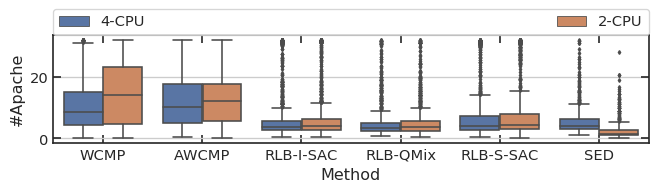

In [561]:
fig = plt.figure(figsize=(8, 1.5), dpi=96)

sns.boxplot(x="Method", y="#Apache", hue="AS Group",
                  data=df_apache, linewidth=1.2, fliersize=2)
# plt.xlabel('')
# plt.ylabel('')
plt.legend(bbox_to_anchor=(0., 1., 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
# plt.ylim([0, 24])
# plt.yticks([0, 8, 16, 24], [0, 8, 16, 24])
# plt.text(0, 18, '{:.2f} queries/s'.format(traffic_rates[2]))

# plt.ylabel('')
fig.savefig(os.path.join(fig_dir, 'wiki', 'wiki-apache.pdf'.format(method, hour)), bbox_inches='tight', transparent=True)

In [554]:
methods = ['ecmp', 'wcmp', 'active-wcmp', 'rlb-iql-test', 'rlb-qmix-test', 'rlb-sa-test', 'sed']
hours = [0, 4, 6, 8]
config_fmt = "hour{}-conf01"
split_by = 3
df_dict = {
    'AS Group': [],
    '#Apache': [],
    'Method': [],
    'Hour': []
}

In [559]:
for method in methods:
    for hour in hours:
        if 'rlb-sa' in method:
            conf = config_fmt.format(str(hour)+'-1lb')
        else:
            conf = config_fmt.format(hour)
        v = [] # ratio
        for ep in range(5):
            if 'rlb' in method:
                filename = "../../data/results/ijcai-lb/wiki_600/{}/{}/0_log_ep{}/logger.log".format(method, conf, ep)
            else:
                filename = "../../data/results/ijcai-lb/wiki_600/{}/{}/0_log_ep{}/lb.log".format(method, conf, ep)
            if not os.path.exists(filename): 
                continue
            lines = read_file(filename)
            lines = lines[int(0.25*len(lines)):int(0.75*len(lines))]
            for l in lines:
                if "Time: " in l:
                    t = float(l.split('Time: ')[-1].strip(" ").strip("s)"))
                if '#apache: ' in l:
                    values = [int(n) for n in l.split('#apache:')[-1].split('|')]
                    n_apache0 = np.mean(values[:split_by])
                    n_apache1 = np.mean(values[split_by:])
                    df_dict['#Apache'].append(n_apache0)
                    df_dict['AS Group'].append('4-CPU')
                    df_dict['Method'].append(METHOD_MAPPER[method])
                    df_dict['Hour'].append(hour)
                    df_dict['#Apache'].append(n_apache1)
                    df_dict['AS Group'].append('2-CPU')
                    df_dict['Method'].append(METHOD_MAPPER[method])
                    df_dict['Hour'].append(hour)
                    v.append(n_apache0/(n_apache1+1e-9))
                else:
                    continue
        if len(v) > 0:
            print('method [{}] (traffic rate {}) #apache thread ratio: avg {:.3f} std {:.3f} median {:.3f} 90p {:.3f}'.format(METHOD_MAPPER[method], traffic_rates[hour], np.mean(v), np.std(v), np.median(v), np.percentile(v, 90)))

method [WCMP] (traffic rate 796.3083333333333) #apache thread ratio: avg 0.863 std 0.543 median 0.807 90p 1.408
method [WCMP] (traffic rate 690.855) #apache thread ratio: avg 1.319 std 1.082 median 1.037 90p 2.360
method [WCMP] (traffic rate 696.5016666666667) #apache thread ratio: avg 0.675 std 0.697 median 0.481 90p 1.486
method [WCMP] (traffic rate 518.7933333333333) #apache thread ratio: avg 14115094.449 std 246913272.297 median 1.556 90p 4.076
method [AWCMP] (traffic rate 796.3083333333333) #apache thread ratio: avg 1.174 std 0.878 median 0.991 90p 1.688
method [AWCMP] (traffic rate 690.855) #apache thread ratio: avg 0.962 std 0.605 median 0.852 90p 1.683
method [AWCMP] (traffic rate 696.5016666666667) #apache thread ratio: avg 1.253 std 1.579 median 0.970 90p 2.217
method [AWCMP] (traffic rate 518.7933333333333) #apache thread ratio: avg 1.554 std 2.380 median 0.914 90p 2.942
method [RLB-I-SAC] (traffic rate 796.3083333333333) #apache thread ratio: avg 0.913 std 0.245 median 0.89

In [560]:
df_apache = pd.DataFrame.from_dict(df_dict)

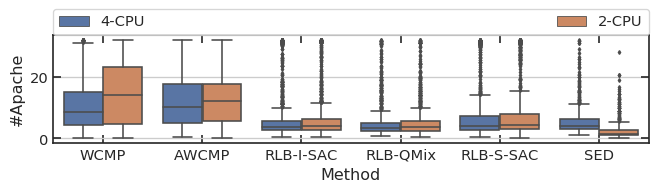

In [561]:
fig = plt.figure(figsize=(8, 1.5), dpi=96)

sns.boxplot(x="Method", y="#Apache", hue="AS Group",
                  data=df_apache, linewidth=1.2, fliersize=2)
# plt.xlabel('')
# plt.ylabel('')
plt.legend(bbox_to_anchor=(0., 1., 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
# plt.ylim([0, 24])
# plt.yticks([0, 8, 16, 24], [0, 8, 16, 24])
# plt.text(0, 18, '{:.2f} queries/s'.format(traffic_rates[2]))

# plt.ylabel('')
fig.savefig(os.path.join(fig_dir, 'wiki', 'wiki-apache.pdf'.format(method, hour)), bbox_inches='tight', transparent=True)

In [366]:
methods_ratio = ['rlb-iql-test', 'rlb-qmix-test', 'rlb-sa-test']
hours = [0, 4, 6, 8]
config_fmt = "hour{}-conf01"
split_by = 3
df_dict = {
    'AS Group': [],
    'Weight': [],
    'Method': [],
    'Hour': []
}

In [367]:
for method in methods_ratio:
    for hour in hours:
        if 'rlb-sa' in method:
            conf = config_fmt.format(str(hour)+'-1lb')
        else:
            conf = config_fmt.format(hour)
        for ep in range(5):
            if 'rlb' in method:
                filename = "../../data/results/ijcai-lb/wiki_600/{}/{}/0_log_ep{}/logger.log".format(method, conf, ep)
            else:
                filename = "../../data/results/ijcai-lb/wiki_600/{}/{}/0_log_ep{}/lb.log".format(method, conf, ep)
            if not os.path.exists(filename): 
                continue
            lines = read_file(filename)
            lines = lines[int(0.25*len(lines)):int(0.75*len(lines))]
            for l in lines:
                if "Time: " in l:
                    t = float(l.split('Time: ')[-1].strip(" ").strip("s)"))
                if 'Last action: ' in l:
                    values = [float(n)*0.2+1 for n in l.split('Last action:')[-1].split('|')]
                    weight0 = np.mean(values[:split_by])
                    weight1 = np.mean(values[split_by:])
                    df_dict['Weight'].append(weight0)
                    df_dict['AS Group'].append('4-CPU')
                    df_dict['Method'].append(METHOD_MAPPER[method])
                    df_dict['Hour'].append(hour)
                    df_dict['Weight'].append(weight1)
                    df_dict['AS Group'].append('2-CPU')
                    df_dict['Method'].append(METHOD_MAPPER[method])
                    df_dict['Hour'].append(hour)
                else:
                    continue

In [363]:
for method in methods_ratio:
    for hour in hours:
        if 'rlb-sa' in method:
            conf = config_fmt.format(str(hour)+'-1lb')
        else:
            conf = config_fmt.format(hour)


        conf = config_fmt.format(hour)
        for ep in range(5):
            if 'rlb' in method:
                filename = "../../data/results/ijcai-lb/wiki_600/{}/{}/0_log_ep{}/logger.log".format(method, conf, ep)
            else:
                filename = "../../data/results/ijcai-lb/wiki_600/{}/{}/0_log_ep{}/lb.log".format(method, conf, ep)
            if not os.path.exists(filename): continue
            lines = read_file(filename)
            lines = lines[int(0.2*len(lines)):int(0.8*len(lines))]
            for l in lines:
                if "Time: " in l:
                    t = float(l.split('Time: ')[-1].strip(" ").strip("s)"))
                if 'Last action: ' in l:
                    values = [float(n)*0.2+1 for n in l.split('Last action:')[-1].split('|')]
                    weight0 = np.mean(values[:split_by])
                    weight1 = np.mean(values[split_by:])
                    df_dict['Weight'].append(weight0)
                    df_dict['AS Group'].append('4-CPU')
                    df_dict['Method'].append(METHOD_MAPPER[method])
                    df_dict['Hour'].append(hour)
                    df_dict['Weight'].append(weight1)
                    df_dict['AS Group'].append('2-CPU')
                    df_dict['Method'].append(METHOD_MAPPER[method])
                    df_dict['Hour'].append(hour)
                else:
                    continue

In [368]:
df_weight = pd.DataFrame.from_dict(df_dict)

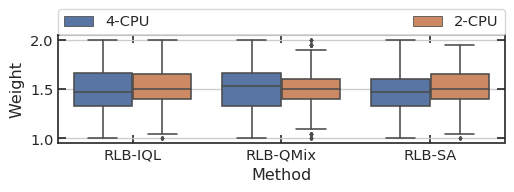

In [371]:
fig = plt.figure(figsize=(6, 1.5), dpi=96)

sns.boxplot(x="Method", y="Weight", hue="AS Group",
                  data=df_weight, linewidth=1.2, fliersize=2)
# plt.xlabel('')
# plt.ylabel('')
plt.legend(bbox_to_anchor=(0., 1., 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
# plt.ylim([0, 24])
# plt.yticks([0, 8, 16, 24], [0, 8, 16, 24])
# plt.text(0, 18, '{:.2f} queries/s'.format(traffic_rates[2]))

# plt.ylabel('')
fig.savefig(os.path.join(fig_dir, 'wiki', 'wiki-weight.pdf'.format(method, hour)), bbox_inches='tight', transparent=True)

## Extension

## Plot page load time

In [556]:
COLORS_DICT = {
    'sed': "#634259", 
    'rlb-qmix-test': "#17b6c8", 
    'rlb-iql-test': "#3978af", 
    'rlb-sa-test': '#559d3f',
    'lsq': "#aecde1",
    'lsq2': "#634295",
    'active-wcmp': "#a65d34",
    'wcmp': "#ef8532", 
    'ecmp': "#d1342b", 
}

MARKER_DICT = {
    'lsq2':       "+",
    'ecmp':       ".",
    'lsq':       "o",
    'sed':    "^",
    'rlb-qmix-test':    "x",
    'rlb-iql-test': "*",
    'active-wcmp': "3",
    'wcmp':   ">",
    'rlb-sa-test':   "v",
}

LINESTYLE_DICT = {
    'lsq2':       "-",
    'active-wcmp': '-',
    'ecmp':       "-",
    'lsq':       "-",
    'sed':    "-",
    'rlb-qmix-test':    "-",
    'rlb-iql-test': "-",
    'wcmp':   "-",
    'rlb-sa-test':   "-",
}

METHOD_MAPPER = {
    'sed': "SED", 
    'rlb-qmix-test': "RLB-QMix", 
    'rlb-sa-test': 'RLB-S-SAC',
    'lsq': "LSQ",
    'lsq2': "LSQ2",
    'active-wcmp': "AWCMP",
    'wcmp': "WCMP", 
    'ecmp': "ECMP", 
    'rlb-iql-test': "RLB-I-SAC",
}

In [634]:
root_dir = "../../data/results/ijcai-lb/wiki_600"
fig_dir = "../../data/figures/ijcai"

In [635]:
methods = ['ecmp', 'wcmp', 'active-wcmp', 'sed', 'rlb-qmix-test', 'rlb-sac-gru-discrete-test']
methods = ['ecmp', 'wcmp', 'active-wcmp', 'rlb-iql-test', 'rlb-qmix-jain-test', 'rlb-sa-test', 'sed', ]
hours = [0, 4, 6, 8]
conf = 'conf01'
trace = 'wiki_600'

In [636]:
page_load_time_res = {}
for hour in hours:
    config = 'hour{:d}-{}'.format(hour, conf)
    page_load_time_res[hour] = {}
    for method in methods:
        if method == 'rlb-sa-test':
            config = 'hour{:d}-1lb-{}'.format(hour, conf)
        else:
            config = 'hour{:d}-{}'.format(hour, conf)
        print("working on config:", config)
        print(">> loading method:", method)
        _task, _dir = get_task_name_dir(trace, method, config)
        page_load_time_res[hour][method] = get_page_load_time(_dir, verbose=True)

working on config: hour0-conf01
>> loading method: ecmp
parsing trace trace_ep0.log
plt all: mean - 4.3070 median - 1.2816 99p - 34.5562
plt wiki: mean - 4.4924 median - 1.6250 99p - 34.6397
plt static: mean - 4.1608 median - 0.9660 99p - 34.5360
parsing trace trace_ep1.log
plt all: mean - 2.7530 median - 0.6372 99p - 31.6029
plt wiki: mean - 2.9189 median - 0.9604 99p - 31.6362
plt static: mean - 2.6220 median - 0.5168 99p - 31.5866
parsing trace trace_ep2.log
plt all: mean - 2.0748 median - 0.4010 99p - 20.3804
plt wiki: mean - 2.3234 median - 0.5953 99p - 22.7942
plt static: mean - 1.8799 median - 0.2347 99p - 18.3087
parsing trace trace_ep3.log
plt all: mean - 1.9115 median - 0.3151 99p - 20.5152
plt wiki: mean - 2.1192 median - 0.5034 99p - 20.8754
plt static: mean - 1.7486 median - 0.2034 99p - 20.1185
parsing trace trace_ep4.log
plt all: mean - 2.9427 median - 0.8499 99p - 31.6103
plt wiki: mean - 3.1972 median - 1.1853 99p - 31.6531
plt static: mean - 2.7418 median - 0.6100 99p

plt all: mean - 0.3828 median - 0.0912 99p - 2.3301
plt wiki: mean - 0.5393 median - 0.2338 99p - 2.5350
plt static: mean - 0.2503 median - 0.0026 99p - 1.7523
parsing trace trace_ep2.log
plt all: mean - 0.1713 median - 0.0255 99p - 1.6312
plt wiki: mean - 0.2806 median - 0.1131 99p - 1.9615
plt static: mean - 0.0784 median - 0.0020 99p - 1.0042
parsing trace trace_ep3.log
plt all: mean - 0.1516 median - 0.0245 99p - 1.3812
plt wiki: mean - 0.2523 median - 0.1089 99p - 1.5794
plt static: mean - 0.0664 median - 0.0020 99p - 0.9623
parsing trace trace_ep4.log
plt all: mean - 0.1282 median - 0.0210 99p - 1.3753
plt wiki: mean - 0.2130 median - 0.0937 99p - 1.6229
plt static: mean - 0.0564 median - 0.0020 99p - 0.8406
working on config: hour4-conf01
>> loading method: active-wcmp
parsing trace trace_ep0.log
plt all: mean - 0.2706 median - 0.0788 99p - 1.8043
plt wiki: mean - 0.4323 median - 0.2859 99p - 2.0215
plt static: mean - 0.1339 median - 0.0024 99p - 1.2125
parsing trace trace_ep1.l

plt all: mean - 0.1668 median - 0.0466 99p - 1.1112
plt wiki: mean - 0.2919 median - 0.1871 99p - 1.3121
plt static: mean - 0.0618 median - 0.0022 99p - 0.6085
parsing trace trace_ep3.log
plt all: mean - 0.2304 median - 0.0534 99p - 1.8045
plt wiki: mean - 0.3644 median - 0.2100 99p - 1.9811
plt static: mean - 0.1179 median - 0.0022 99p - 1.6573
parsing trace trace_ep4.log
plt all: mean - 0.1759 median - 0.0508 99p - 1.1352
plt wiki: mean - 0.2887 median - 0.1734 99p - 1.3474
plt static: mean - 0.0809 median - 0.0023 99p - 0.7874
working on config: hour6-conf01
>> loading method: rlb-iql-test
parsing trace trace_ep0.log
plt all: mean - 0.0666 median - 0.0116 99p - 0.7223
plt wiki: mean - 0.1357 median - 0.0753 99p - 0.9236
plt static: mean - 0.0085 median - 0.0018 99p - 0.1613
parsing trace trace_ep1.log
plt all: mean - 0.1077 median - 0.0148 99p - 1.1796
plt wiki: mean - 0.1940 median - 0.0839 99p - 1.4401
plt static: mean - 0.0351 median - 0.0019 99p - 0.6973
parsing trace trace_ep2.

plt all: mean - 0.0306 median - 0.0069 99p - 0.2154
plt wiki: mean - 0.0622 median - 0.0495 99p - 0.2756
plt static: mean - 0.0030 median - 0.0019 99p - 0.0161
working on config: hour8-conf01
>> loading method: rlb-qmix-jain-test
parsing trace trace_ep0.log
plt all: mean - 0.0341 median - 0.0074 99p - 0.2510
plt wiki: mean - 0.0696 median - 0.0518 99p - 0.3486
plt static: mean - 0.0031 median - 0.0019 99p - 0.0174
parsing trace trace_ep1.log
plt all: mean - 0.0312 median - 0.0064 99p - 0.2167
plt wiki: mean - 0.0636 median - 0.0500 99p - 0.2674
plt static: mean - 0.0030 median - 0.0019 99p - 0.0161
parsing trace trace_ep2.log
plt all: mean - 0.0306 median - 0.0074 99p - 0.2102
plt wiki: mean - 0.0622 median - 0.0496 99p - 0.2688
plt static: mean - 0.0030 median - 0.0019 99p - 0.0163
parsing trace trace_ep3.log
plt all: mean - 0.0317 median - 0.0080 99p - 0.2245
plt wiki: mean - 0.0641 median - 0.0492 99p - 0.3699
plt static: mean - 0.0033 median - 0.0019 99p - 0.0200
parsing trace trac

=== hour 0 (traffic rate 796.308) ===
method [ECMP] page load time (wiki): avg 3018.51(±837.34) std 6206.80(±1656.24) median 0.985 90p 6.495
method [WCMP] page load time (wiki): avg 446.75(±269.41) std 677.39(±281.76) median 0.169 90p 1.275
method [AWCMP] page load time (wiki): avg 539.07(±152.40) std 691.40(±256.47) median 0.341 90p 1.257
method [RLB-I-SAC] page load time (wiki): avg 155.02(±96.97) std 248.33(±114.90) median 0.070 90p 0.371
method [RLB-QMix] page load time (wiki): avg 188.81(±104.73) std 320.99(±124.85) median 0.076 90p 0.473
method [RLB-S-SAC] page load time (wiki): avg 398.87(±367.33) std 569.72(±235.62) median 0.142 90p 1.150
method [SED] page load time (wiki): avg 150.91(±69.20) std 229.83(±92.12) median 0.071 90p 0.398
method [ECMP] page load time (static): avg 2636.83(±859.69) std 6238.00(±1857.34) median 0.505 90p 5.553
method [WCMP] page load time (static): avg 192.52(±181.47) std 496.06(±281.34) median 0.002 90p 0.661
method [AWCMP] page load time (static): a

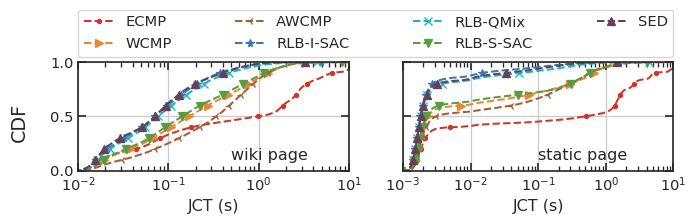

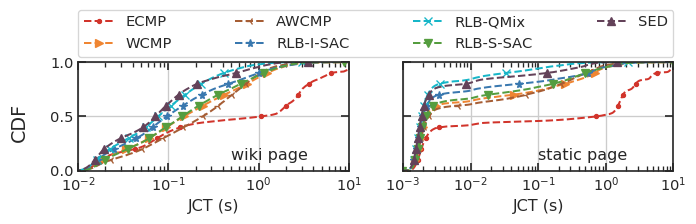

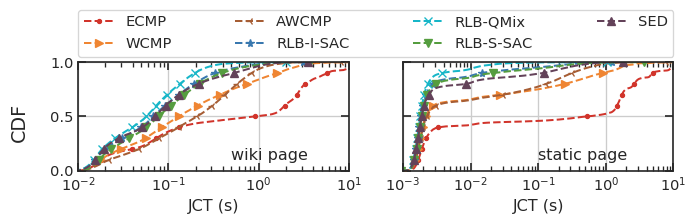

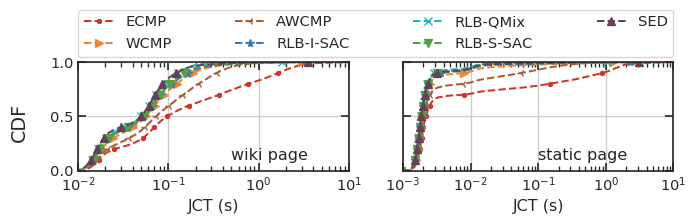

In [566]:
# xlims=[[1e-2, 3],[1e-2, 10]]
xlims=[[1e-2, 10],[1e-3, 10]]
n_subplots = 2
# xlim=None
for hour in hours:
    print("=== hour {} (traffic rate {:.3f}) ===".format(hour, traffic_rates[hour]))
    fig, axs = plt.subplots(1, n_subplots, figsize=(8, 1.5), dpi=96, sharex=False, sharey=True)
    fig.suptitle('CDF', position=(0.048, .6), rotation='vertical')
    for i, ylabel, xlim in zip(range(n_subplots), ['wiki', 'static'], xlims):
        for method in methods:
            if method == 'sed' and conf == '1lb-conf01': continue
            if method == 'rlb-qmix-test' and conf == '1lb-conf01': continue
            v = page_load_time_res[hour][method]['plt_{}'.format(ylabel)]
            print('method [{}] page load time ({}): avg {:.2f}(±{:.2f}) std {:.2f}(±{:.2f}) median {:.3f} 90p {:.3f}'.format(METHOD_MAPPER[method], ylabel, 1000*np.mean(v), 1000*np.std([np.mean(values_[ylabel]) for values_ in page_load_time_res[hour][method]['plt_by_ep'].values()]), 1000*np.std(v), 1000*np.std([np.std(values_[ylabel]) for values_ in page_load_time_res[hour][method]['plt_by_ep'].values()]), np.median(v), np.percentile(v, 90)))
            color = COLORS_DICT[method]
            marker = MARKER_DICT[method]
            linestyle = LINESTYLE_DICT[method]
            if conf == 'conf01': linestyle = '--'
            percentiles = [np.percentile(v, p) for p in range(0, 110, 10)]
            axs[i].semilogx(np.sort(v), np.linspace(0, 1, len(v), endpoint=False), linestyle=linestyle, color=color)
            axs[i].semilogx(percentiles, np.linspace(0, 1, 11, endpoint=True), linestyle='', marker=marker, color=color)
            axs[i].plot([0.], [0.], linestyle=linestyle, marker=marker, color=color, label=METHOD_MAPPER[method])

        axs[i].set_xlim(xlim)
        axs[i].set_ylim([0.,1.])
        axs[i].grid(True)
        plt.sca(axs[i])
        if i == 0:
            plt.text(0.5, 0.1, '{} page'.format(ylabel))
        else:
            plt.text(0.1, 0.1, '{} page'.format(ylabel))


    #     axs[i].set_title()
        axs[i].set_xlabel('FCT (s)')
        if i == 0: axs[i].legend(bbox_to_anchor=(0., 1.05, 2.2, .102), loc='lower left',
               ncol=4, mode="expand", borderaxespad=0.)

#     fig.savefig(os.path.join(fig_dir, 'wiki', 'rlb-wiki-hour{}-{}.pdf'.format(hour, conf)), bbox_inches='tight', transparent=True)
# axs[i].set_xlabel("FCT (s)")

=== hour 0 (traffic rate 796.308) ===
=== hour 6 (traffic rate 696.502) ===
=== hour 4 (traffic rate 690.855) ===
=== hour 8 (traffic rate 518.793) ===


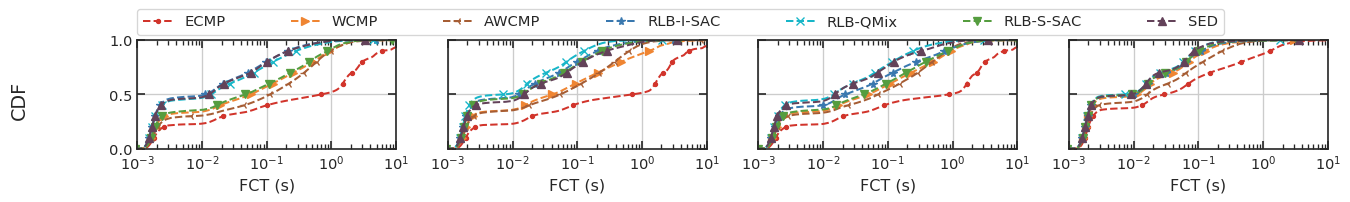

In [571]:
# xlims=[[1e-2, 3],[1e-2, 10]]
xlims=[[1e-2, 10],[1e-3, 10]]
n_subplots = 2
# xlim=None
fig, axs = plt.subplots(1, len(hours), figsize=(len(hours)*4, 1.5), dpi=96, sharex=False, sharey=True)
fig.suptitle('CDF', position=(0.048, .6), rotation='vertical')

for i, hour in enumerate([0, 6, 4, 8]):
    print("=== hour {} (traffic rate {:.3f}) ===".format(hour, traffic_rates[hour]))
    for method in methods:
        if method == 'sed' and conf == '1lb-conf01': continue
        if method == 'rlb-qmix-test' and conf == '1lb-conf01': continue
        v = page_load_time_res[hour][method]['page_load_time']
#             print('method [{}] page load time ({}): avg {:.2f}(±{:.2f}) std {:.2f}(±{:.2f}) median {:.3f} 90p {:.3f}'.format(METHOD_MAPPER[method], ylabel, 1000*np.mean(v), 1000*np.std([np.mean(values_[ylabel]) for values_ in page_load_time_res[hour][method]['plt_by_ep'].values()]), 1000*np.std(v), 1000*np.std([np.std(values_[ylabel]) for values_ in page_load_time_res[hour][method]['plt_by_ep'].values()]), np.median(v), np.percentile(v, 90)))
        color = COLORS_DICT[method]
        marker = MARKER_DICT[method]
        linestyle = LINESTYLE_DICT[method]
        if conf == 'conf01': linestyle = '--'
        percentiles = [np.percentile(v, p) for p in range(0, 110, 10)]
        axs[i].semilogx(np.sort(v), np.linspace(0, 1, len(v), endpoint=False), linestyle=linestyle, color=color)
        axs[i].semilogx(percentiles, np.linspace(0, 1, 11, endpoint=True), linestyle='', marker=marker, color=color)
        axs[i].plot([0.], [0.], linestyle=linestyle, marker=marker, color=color, label=METHOD_MAPPER[method])

    axs[i].set_xlim(xlim)
    axs[i].set_ylim([0.,1.])
    axs[i].grid(True)
    plt.sca(axs[i])

    #     axs[i].set_title()
    axs[i].set_xlabel('FCT (s)')
    if i == 0: axs[i].legend(bbox_to_anchor=(0., 1.05, 4.2, .102), loc='lower left',
           ncol=7, mode="expand", borderaxespad=0.)

    fig.savefig(os.path.join(fig_dir, 'wiki', 'rlb-wiki-hour{}-{}-all.pdf'.format(hour, conf)), bbox_inches='tight', transparent=True)
# axs[i].set_xlabel("FCT (s)")

# analyse QMix centralized training delay

In [643]:
methods = ['rlb-qmix-jain', 'rlb-qmix-jain-test']
# methods = ['ecmp', 'wcmp', 'active-wcmp', 'lsq', 'sed', 'rlb-iql', 'rlb-qmix-jain', 'rlb-sac-gru-discrete']

In [619]:
traces = ['wiki_600', 'poisson_benchmark']
root_dir = '/home/yzy/Load-Balancer/data/results/ijcai-lb'

In [621]:
dts_dict = {}
for method in methods:
    dts_dict[method] = {}
    for trace in traces:
        log_folders = !find {root_dir}/{trace}/{method} -name '0_log_ep*'
        dts = []
        for folder in log_folders:
            lines = read_file(os.path.join(folder, 'logger.log'))
            time_steps = np.array([float(l.strip(' ').split('Time: ')[-1].rstrip('s)')) for l in lines if '(Time: ' in l])
            dts.append(time_steps[1:]-time_steps[:-1])
        dts = np.concatenate(dts)
        dts_dict[method][trace] = dts

In [597]:
trace = traces[1]

In [598]:
log_folders = !find {root_dir}/{trace}/{method} -name '0_log_ep*'

In [599]:
dts = []
for folder in log_folders:
    lines = read_file(os.path.join(folder, 'logger.log'))
    time_steps = np.array([float(l.strip(' ').split('Time: ')[-1].rstrip('s)')) for l in lines if '(Time: ' in l])
    dts.append(time_steps[1:]-time_steps[:-1])

In [600]:
dts = np.concatenate(dts)

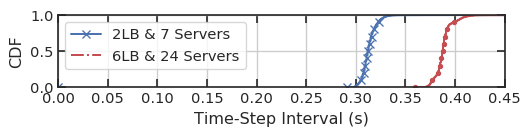

In [625]:
fig = plt.figure(figsize=(6,1), dpi=96)
linestyles = ['-', '-.']
markers = ['x', '.']
# DTS_METHODS = ['QMix (Train)', 'QMix (Test)']
colors = ['b', 'r']
DTS_LABELS = ['2LB & 7 Servers', '6LB & 24 Servers']

for i, method in enumerate(methods[:1]):
    for j, trace in enumerate(traces):
        data = dts_dict[method][trace]
        color = colors[j]
        linestyle = linestyles[j]
        marker = markers[j]
        percentiles = [np.percentile(data, p) for p in range(0, 110, 10)]
        plt.plot(np.sort(data), np.linspace(0, 1, len(data), endpoint=False), linestyle, color=color)
        plt.plot(percentiles, np.linspace(0, 1, 11, endpoint=True), marker, color=color)
#     plt.plot(0, 0, linestyles[i], color='k', label=DTS_METHODS[i])
for j in range(2):
    plt.plot(0, 0, '-{}'.format(markers[j]), color=colors[j], label=DTS_LABELS[j])
plt.xlim([0., .45])
# plt.xticks([0.25, 0.3, 0.35, 0.4, 0.5], [0.25, 0.3, 0.35, 0.4, 0.5])
plt.ylim([0, 1])
plt.ylabel("CDF")
plt.legend()
plt.xlabel('Time-Step Interval (s)')
fig.savefig(os.path.join('../../data/figures/ijcai', 'qmix-communication.pdf'), bbox_inches='tight', transparent=True)

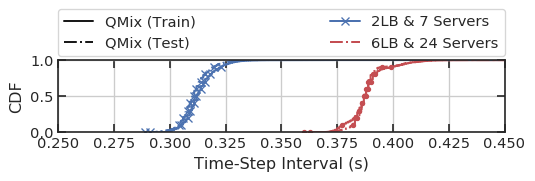

In [648]:
fig = plt.figure(figsize=(6,1), dpi=96)
linestyles = ['-', '-.']
markers = ['x', '.']
DTS_METHODS = ['QMix (Train)', 'QMix (Test)']
colors = ['b', 'r']
DTS_LABELS = ['2LB & 7 Servers', '6LB & 24 Servers']

for i, method in enumerate(methods):
    for j, trace in enumerate(traces):
        data = dts_dict[method][trace]
        color = colors[j]
        linestyle = linestyles[i]
        marker = markers[j]
        percentiles = [np.percentile(data, p) for p in range(0, 110, 10)]
        plt.plot(np.sort(data), np.linspace(0, 1, len(data), endpoint=False), linestyle, color=color)
        plt.plot(percentiles, np.linspace(0, 1, 11, endpoint=True), marker, color=color)
    plt.plot(0, 0, linestyles[i], color='k', label=DTS_METHODS[i])
for j in range(2):
    plt.plot(0, 0, '-{}'.format(markers[j]), color=colors[j], label=DTS_LABELS[j])
plt.xlim([0.25, .45])
# plt.xticks([0.25, 0.3, 0.35, 0.4, 0.5], [0.25, 0.3, 0.35, 0.4, 0.5])
plt.legend(bbox_to_anchor=(0., 1.05, 1., .102), loc='lower left',
               ncol=2, mode="expand", borderaxespad=0.)

plt.ylim([0, 1])
plt.ylabel("CDF")
# plt.legend()
plt.xlabel('Time-Step Interval (s)')
fig.savefig(os.path.join('../../data/figures/ijcai', 'qmix-communication.pdf'), bbox_inches='tight', transparent=True)